# IACAH (India Academia Connect AI Hackathon)

Date - October 4-13, 2021

Artificial intelligence will be an enormous part of the future workforce. It’s expected to generate 2 million net job gains versus losses by 2025. India Academia Connect AI Hackathon will help the participants from leading research institutions with the opportunity to learn and implement the latest AI technology, preparing them for a future AI-powered economy, with a large research and developer base.

Data Download Link:- [GDrive Link](https://drive.google.com/drive/folders/1O8TT0s4zMyiI6zR-biVRoiLiAUy-W1H0?usp=sharing)

#### Primary Goal:- To classify the Images into Background and Text
    To Classify the Images into two categories(Background or Text) using Tensorflow and Keras.

#### Solution:- 
    It's a Binary Class classification problem. It can be solved using CNN classifier.
    Train the Model using transfer learning. We used VGG16 as feature extractor and used Dropout to avoid overfitting. we used some ImageDataAugmentation technique to make model more robust and better. we are using modelcheckpoint and earlystopping callbacks function to get the best model possible

#### Result:- 
    we evalute the model on test_data(unseen data) using evlaute function and got the approx 92% accuracy. The Accuracy may be improve using new model like Resnet or Imagenet. Although Vgg16 is also works as feature extractor.

In [30]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image

In [31]:
train_dir = "training" 
test_dir = "test"
batch_size = 50
img_size = (64, 64)
num_class = len(os.listdir(train_dir))
idx_to_name = os.listdir(train_dir)
name_to_idx = dict([(v, k) for k, v in enumerate(idx_to_name)])

In [106]:
def data_to_df(data_dir, subset=None):
    ''' Creating DataFrame for loading Filename and Label
    
    Args:
        Data_dir: 
            Data_dir Path
        Subset: 
            - train- for spliting data in train and val
    
     '''
    df = pd.DataFrame(columns=['filenames', 'labels'])

    filenames = []
    labels = []
    for dataset in os.listdir(data_dir):
        img_list = os.listdir(os.path.join(data_dir, dataset))

        label = name_to_idx[dataset]

        for image in img_list:
            filenames.append(os.path.join(data_dir, dataset, image))
            labels.append(label)

    df["filenames"] = filenames
    df["labels"] = labels
    
    if subset == "train":
        train_df, val_df = train_test_split(df, train_size=0.9, shuffle=True)    
        return train_df, val_df
    return df

In [107]:
train_df, val_df = data_to_df(train_dir, subset="train")
root_dir = os.path.dirname(os.path.abspath("training.py"))

In [131]:
class CustomDataGenerator:
    ''' Custom DataGenerator to load img '''
    def __init__(self, data_frame):
        self.data_frame = data_frame
    
    def load_samples(self):
        ''' Convert DataFrame into List '''
        data = self.data_frame
        data = data[["filenames", "labels"]]
        filenames = list(data["filenames"])
        labels = list(data["labels"])

        samples = []
        for filename, label in zip(filenames, labels):
            samples.append([filename, label])
        return samples
    
    def __len__(self):
        return len(self.data_frame)
    
    def preprocessing(self, img, label):
        img = np.resize(img, (64, 64, 3))
        img = preprocess_input(img)
        return img, label

    def generators(self, samples, batch_size=10, shuffle_data=True):
        ''' Generator function to yield img and laebl '''
        num_samples = len(samples)
        while True:
            samples = shuffle(samples)
            for offset in range(0, num_samples, batch_size):
                batch_samples = samples[offset:offset+batch_size]
                
                X_train = []
                y_train = []

                for batch_sample in batch_samples:
                    img_name = batch_sample[0]
                    label = batch_sample[1]

                    img = np.asarray(Image.open(os.path.join(root_dir, img_name)))
                    img, label = self.preprocessing(img, label)

                    X_train.append(img)
                    y_train.append(label)

                X_train = np.array(X_train)
                y_train = np.array(y_train)

                yield X_train, y_train

In [109]:
# creating customDataGenerator object
train_datagen = CustomDataGenerator(train_df)
val_datagen = CustomDataGenerator(val_df)

In [110]:
# creating sample with dataframe
train_sample = train_datagen.load_samples()
val_sample = val_datagen.load_samples()

In [111]:
# creating train and validation data
train_data = train_datagen.generators(train_sample, batch_size=batch_size)
val_data = val_datagen.generators(val_sample, batch_size=batch_size)

In [112]:
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
base_model.trainable= True

In [113]:
inputs = layers.Input(shape=(64, 64, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

In [114]:
model = Model(inputs, outputs, name="VGG16")

In [115]:
model.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 14,780,481
Non-trainable params: 0
_________________________________________________

In [116]:
model.compile(
    optimizer="adam",
    loss=BinaryCrossentropy(),
    metrics=["accuracy"])

In [117]:
modelcheckpoint = ModelCheckpoint(
    "tmp",
    save_best_only=True)

earlystopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True)

In [118]:
callbacks = [earlystopping, modelcheckpoint]

In [119]:
try:
    model.load_weights("tmp")
    print("Loading weight from last checkpoint")
except Exception as e:
    print("no weight found. Training from scratch")

Loading weight from last checkpoint


In [120]:
history = model.fit(
    train_data,
    epochs=15,
    batch_size=batch_size,
    steps_per_epoch=len(train_sample)//batch_size,
    validation_data=val_data,
    validation_steps=len(val_sample)//batch_size,
    callbacks=callbacks)

Epoch 1/15
105/105 [==============================] - 17s 149ms/step - loss: 0.0167 - accuracy: 0.9973 - val_loss: 0.0059 - val_accuracy: 0.9982
INFO:tensorflow:Assets written to: tmp/assets
Epoch 2/15
105/105 [==============================] - 17s 147ms/step - loss: 0.0314 - accuracy: 0.9905 - val_loss: 0.0148 - val_accuracy: 0.9964
Epoch 3/15
105/105 [==============================] - 15s 147ms/step - loss: 0.0116 - accuracy: 0.9977 - val_loss: 0.0258 - val_accuracy: 0.9927
Epoch 4/15
105/105 [==============================] - 16s 148ms/step - loss: 0.0215 - accuracy: 0.9935 - val_loss: 0.0660 - val_accuracy: 0.9764
Epoch 5/15
105/105 [==============================] - 15s 147ms/step - loss: 0.0605 - accuracy: 0.9811 - val_loss: 0.0605 - val_accuracy: 0.9818
Epoch 6/15
105/105 [==============================] - 15s 147ms/step - loss: 0.0317 - accuracy: 0.9927 - val_loss: 0.0420 - val_accuracy: 0.9818


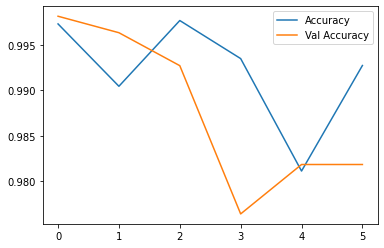

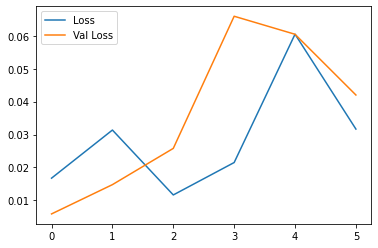

In [121]:
his = history.history

plt.plot(his["accuracy"])
plt.plot(his["val_accuracy"])
plt.legend(["Accuracy", "Val Accuracy"])
plt.show()

plt.plot(his["loss"])
plt.plot(his["val_loss"])
plt.legend(["Loss", "Val Loss"])
plt.show()

In [122]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [123]:
test_data = test_datagen.flow_from_directory(
    "test2",
    batch_size=batch_size,
    target_size=img_size,
    class_mode="binary")

Found 98 images belonging to 2 classes.


In [124]:
loss, accuracy = model.evaluate(test_data)

2/2 [==============================] - 0s 60ms/step - loss: 1.2595 - accuracy: 0.8878


In [125]:
print("Loss on Test Data", loss)
print("Accuracy on Test Data", accuracy)

Loss on Test Data 1.259535789489746
Accuracy on Test Data 0.8877550959587097


In [127]:
# Creating Json File to submit the solution
final_output = {}
for folder in os.listdir("test2"):
    for image_name in os.listdir(os.path.join("test2", folder)):
        img_ = image.load_img(os.path.join("test2", folder, image_name), 
                              target_size=(64, 64), color_mode="rgb")
        img_arr = image.img_to_array(img_)
        img_arr = preprocess_input(img_arr)
        img_batch = np.array([img_arr])
        output = model.predict(img_batch)
        if output > 0.5:
            final_output[image_name] = 1
        else:
            final_output[image_name] = 0

In [128]:
with open("result.json", "w") as file:
    json.dump(final_output, file)

In [129]:
!zip -r tmp.zip tmp

updating: tmp/ (stored 0%)
updating: tmp/assets/ (stored 0%)
updating: tmp/saved_model.pb (deflated 90%)
updating: tmp/keras_metadata.pb (deflated 96%)
updating: tmp/variables/ (stored 0%)
updating: tmp/variables/variables.data-00000-of-00001 (deflated 15%)
updating: tmp/variables/variables.index (deflated 74%)


In [130]:
from google.colab import files
files.download("tmp.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>